```
# How to improve my score, review of important issue
# Image Augmentation examples
# How to improve 0.1 point using simple ensemble
# Images that fail to classify on the testset
```

- 커널 코드 참고
```
    # Daehun Gwak, Keras, How to use pretrained model?
    # Jang, [3rd ML Month] Car Model Classification (Xception)
```
- 성능개선을 위한 중요한 사항
```
    - train / test 세트 분할시 stratfy 적용
    - 이미지 전처리, 스케일링 적용 (rescale=1./255) 
    - image augmentation 단계에서 필터/노이즈 적용 -> ImageDataGenerator에 함수적용
    - ReduceLROnPlateau, EarlyStopping 파라메타 조정
    - 10개 모델 앙상블 (0.01 상승)
    - 테스트셋에서 잘 분류되지 않는 이미지들 확인 -> 뒷면,윗면,표면반사,표면무늬
    - 테스트셋에서 잘분류된 이미지들을 학습셋으로 사용
    - 5 kfold, 교차검증 가능한가?
```

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'test', 'train', 'train.csv', 'class.csv', 'sample_submission.csv']


In [2]:
import warnings
import pandas as pd
from tqdm import tqdm
import matplotlib.pylab as plt
import PIL
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers, models, optimizers

warnings.filterwarnings('ignore')

image_size = 224

Using TensorFlow backend.


In [3]:
# 이미지 폴더 경로
DATA_PATH = '../input/'

TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

In [4]:
def crop_boxing_img(img_name, margin=16, size=(image_size, image_size)):
    if img_name.split('_')[0] == 'train':
        PATH = TRAIN_IMG_PATH
        data = df_train
    else:
        PATH = TEST_IMG_PATH
        data = df_test

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1, y1, x2, y2)).resize(size)

In [5]:
TRAIN_CROP_PATH = "./train_crop"
TEST_CROP_PATH = "./test_crop"

In [6]:
!mkdir {TRAIN_CROP_PATH}

In [7]:
!mkdir {TEST_CROP_PATH}

In [8]:
for i, row in df_train.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    cropped.save(f"{TRAIN_CROP_PATH}/{row['img_file']}")
    
for i, row in df_test.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    cropped.save(f"{TEST_CROP_PATH}/{row['img_file']}")

In [9]:
from sklearn.model_selection import train_test_split

df_train["class"] = df_train["class"].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.9, 
                                      random_state=0,
                                      shuffle= True, 
                                      stratify= df_train['class'])
# stratify를 해주는게 좋다. class의 분포를 균등하게
X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_test.shape)

(8991, 2)
(999, 2)
(6150, 1)


In [10]:
# image augmentation에 사용할 함수

from skimage.transform import warp, AffineTransform, ProjectiveTransform
from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity, adjust_gamma, adjust_log, adjust_sigmoid
from skimage.filters import gaussian
from skimage.util import random_noise
import random

def randRange(a, b):
    return np.random.rand() * (b - a) + a

def randomCrop(im):
    '''
    croping the image in the center from a random margin from the borders
    '''
    margin = 1/10
    start = [int(randRange(0, im.shape[0] * margin)),
             int(randRange(0, im.shape[1] * margin))]
    end = [int(randRange(im.shape[0] * (1-margin), im.shape[0])), 
           int(randRange(im.shape[1] * (1-margin), im.shape[1]))]
    return im[start[0]:end[0], start[1]:end[1]]

def randomIntensity(im):
    '''
    rescales the intesity of the image to random interval of image intensity distribution
    '''
    return rescale_intensity(im,
                             in_range=tuple(np.percentile(im, (randRange(0,10), randRange(90,100)))),
                             out_range=tuple(np.percentile(im, (randRange(0,10), randRange(90,100)))))

def randomGamma(im):
    '''
    Gamma filter for contrast adjustment with random gamma value.
    '''
    return adjust_gamma(im, gamma=randRange(0.5, 1.5))

def randomGaussian(im):
    '''
    Gaussian filter for bluring the image with random variance.
    '''
    return gaussian(im, sigma=randRange(0, 5))

def randomFilter(im):
    '''
    randomly selects an exposure filter from histogram equalizers, contrast adjustments, and intensity rescaler and applys it on the input image.
    filters include: equalize_adapthist, equalize_hist, rescale_intensity, adjust_gamma, adjust_log, adjust_sigmoid, gaussian
    '''
    Filters = [equalize_adapthist, equalize_hist, adjust_log, adjust_sigmoid, randomGaussian, randomIntensity, randomGamma]
    filt = random.choice(Filters)
    return filt(im)

def randomNoise(im):
    '''
    random gaussian noise with random variance.
    '''
    var = randRange(0.001, 0.01)
    return random_noise(im, var=var)

def noFilter(im):
    return im

def augment(im, Steps= [noFilter, randomFilter, randomNoise]):
    
    im /= 255. # 추가    
    i= np.random.randint(3)
    step = Steps[i]
    im = step(im)
    return im


In [11]:
import keras 

from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',  
    preprocessing_function=augment)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
img_size = (image_size, image_size)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
epochs = 3 # 실제 학습시 epoch는 100이상
batch_size = 64


train_generator = train_datagen.flow_from_dataframe(
    dataframe = X_train, 
    directory = TRAIN_CROP_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size =batch_size,
    shuffle =True
)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe = X_val, 
    directory = TRAIN_CROP_PATH,
    x_col ='img_file',
    y_col ='class',
    target_size = img_size,
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size =batch_size,
    shuffle =False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = TEST_CROP_PATH,
    x_col ='img_file',
    y_col =None,
    target_size = img_size,
    color_mode ='rgb',
    class_mode =None,
    batch_size =batch_size,
    shuffle = False
)


Found 8991 validated image filenames belonging to 196 classes.
Found 999 validated image filenames belonging to 196 classes.
Found 6150 validated image filenames.


In [14]:
augmentation 처리된 이미지들을 확인할 수 있다.

for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break
    
import matplotlib.pyplot as plt
from keras.preprocessing import image

for i in range(5):    
    plt.imshow(image.array_to_img(data_batch[i]))
    plt.show()
       

SyntaxError: invalid syntax (<ipython-input-14-e71b2113fa24>, line 1)

In [15]:
from keras.applications.xception import Xception
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Dense

keras.backend.clear_session()

base_model = Xception(weights = 'imagenet', include_top= False, 
                 input_shape= (image_size,image_size,3))

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(196, activation='softmax'))


83689472/83683744 [==============================] - 1s 0us/step


In [16]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = keras.optimizers.adamax(lr=0.001),
             metrics=['accuracy'])

# model.compile(loss = 'categorical_crossentropy',
#              optimizer = 'adam',
#              metrics=['accuracy'])

In [17]:
lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', # val_acc -> val_loss
                                patience = 3, # 4
                                verbose = 1,
                                factor = 0.5, #0.5
                                min_lr = 0.00001)

es = EarlyStopping(monitor = 'val_acc', 
                  min_delta = 0, # 개선되고 있다고 판단하기 위한 최소 변화량
                  patience = 6, # 개선 없는 epoch을 얼마나 기다릴지
                  verbose = 1
                  )


In [18]:
# model_path = '../model/'
# if not os.path.exists(model_path):
#     os.mkdir(model_path)
model_path = 'best_model.hdf5'

mc = ModelCheckpoint(filepath=model_path,
                     monitor='val_loss',
                     save_best_only=True)

In [19]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else :
        return num_samples // batch_size

In [20]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = [es, lr_reduction, mc],
    verbose=1
)


Epoch 1/3
141/141 [==============================] - 193s 1s/step - loss: 5.2792 - acc: 0.0044 - val_loss: 5.2777 - val_acc: 0.0080
Epoch 2/3
141/141 [==============================] - 172s 1s/step - loss: 5.2778 - acc: 0.0079 - val_loss: 5.2772 - val_acc: 0.0080
Epoch 3/3
141/141 [==============================] - 171s 1s/step - loss: 5.2773 - acc: 0.0083 - val_loss: 5.2768 - val_acc: 0.0080


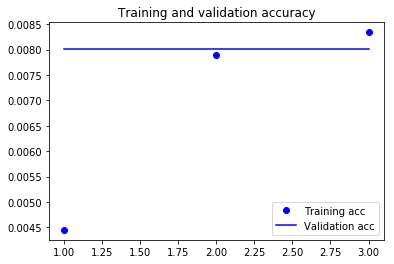

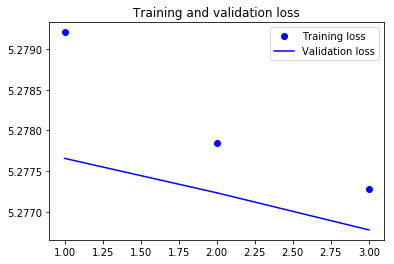

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
!rm -rf *_crop 
# 캐글 커널 commit을 위해서 생성된 파일들은 모두 지워야함.
# output파일이 많으면 commit에러

In [23]:
# model.load_weights(model_path)
# test_generator.reset()

# prediction = model.predict_generator(
#     generator=test_generator,
#     steps = get_steps(nb_test_samples, batch_size),
#     verbose=1
# )

In [24]:
# predicted_class_indices=np.argmax(prediction, axis=1)

# # Generator class dictionary mapping
# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]

# submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
# submission["class"] = predictions
# submission.to_csv("submission_190627.csv", index=False)
# submission.head() # [124,  98, 157,  94,  18]

In [25]:
# submission.tail() #[91,79,44,50,94]

In [26]:
# model.save('xception_190627.h5')

<a href="submission_190627.csv"> Download Submission </a> <br>
<a href= "xception_190627.h5"> Download Model </a>